In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F

In [2]:
runs = RunStats.objects.filter(
    query=365,
    limit=0,
    method = 'NM',
    min_freq=5,
    error__gt=0
).annotate(
    topics = models.Count('topic'),
)
df =  pd.DataFrame.from_dict(list(runs.values()))

In [3]:
df.head()

,K,alpha,batch_count,db,db_time,docs_seen,dthreshold,empty_topics,error,errortype,...,query_id,run_id,start,status,term_count,tfidf_time,topic_scores_current,topic_titles_current,topic_year_scores_current,topics
0,20,0.05,0,False,0.000000,NaN,0.0005,0.0,480.311351,Frobenius,...,365,455,2017-11-28 15:39:25.351739+00:00,3,NaN,1338.175046,False,False,False,0
1,100,0.10,0,True,7161.210633,254089.0,0.0029,NaN,456.176429,Frobenius,...,365,381,2017-11-03 10:03:32.327105+00:00,3,57754.0,1349.347580,True,True,True,100
2,100,0.05,0,True,10789.129200,254089.0,0.0024,NaN,456.220244,Frobenius,...,365,386,2017-11-13 08:38:13.957416+00:00,3,57741.0,1321.025046,True,True,True,100
3,50,0.05,0,False,0.000000,NaN,0.0005,0.0,469.077339,Frobenius,...,365,458,2017-11-28 16:01:26.391685+00:00,3,NaN,1329.797706,False,False,False,0
4,100,0.10,0,True,5166.223380,254088.0,0.0005,NaN,456.605281,Frobenius,...,365,380,2017-11-02 16:38:27.199413+00:00,3,57754.0,1330.187915,True,True,True,100


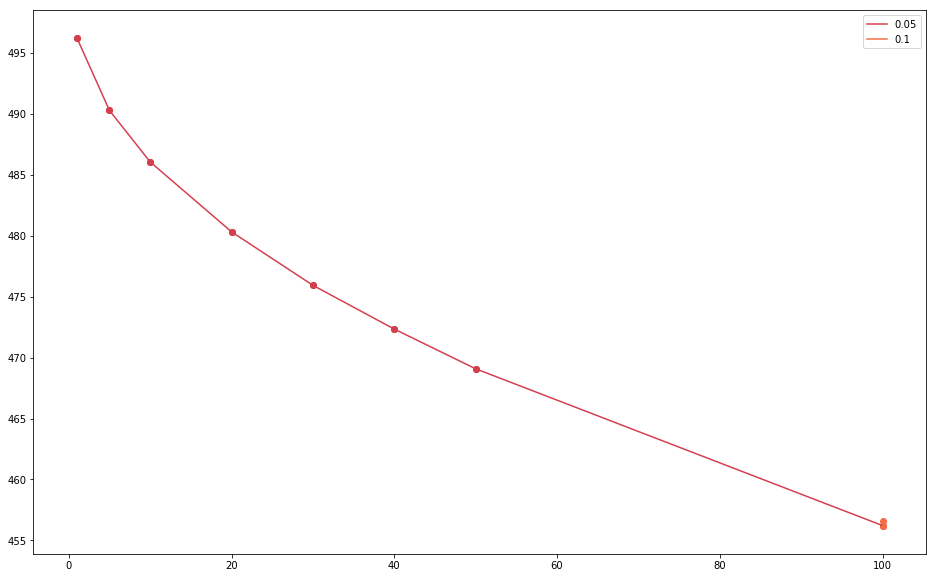

In [4]:
ndf = df.sort_values(by='topics', ascending=1).reset_index(drop=True)

colorset=["#d53e4f","#f46d43","#fdae61","#fee08b","#e6f598","#abdda4","#66c2a5","#3288bd"]
plt.rcParams["figure.figsize"] = [16,10]
gndf = ndf.groupby(['alpha'])
ps = []
gs = []
i = 0
for name,group in gndf:
    #if name == 0.1:
     #   continue
    group = group.sort_values('K')
   # group = group[(group['K'] > 90) & (group['K'] < 150)]
    p = plt.plot(group['K'],group['error'],color=colorset[i])
    plt.scatter(group['K'],group['error'],color=colorset[i])
    plt.scatter(group['K'],group['error']+group['empty_topics']*5,color=colorset[i])
    #m = group[group['topics']==150]
   # plt.text(
   #     m['topics'],
   #     m['error'],name
   # )
    ps.append(p[0])
    gs.append(name)
    i+=1
#p1 = plt.plot(ndf['topics'],ndf[ndf[max_features==5000]]['error'],color='#fbb4ae')
#p2 = plt.plot(ndf['topics'],ndf['iterations'],color='#b3cde3')
plt.legend((ps),(gs))

plt.show()